In [1]:
import pandas as pd
import matplotlib
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Načítanie datasetov train a test vytvorenýchv druhej fáze

In [2]:
train = pd.read_csv('train.csv', sep="\t")
test = pd.read_csv('test.csv', sep="\t")

In [3]:
train.head()

,PM2.5,warning,O3,PM10,CH4
0,0.287582,1.0,0.671865,0.443656,0.410243
1,0.197105,0.0,0.478470,0.372079,0.611069
2,0.843501,0.0,0.176255,0.697878,0.712391
3,0.579503,0.0,0.440616,0.418235,0.517275
4,0.768282,1.0,0.830880,0.694914,0.420542


In [4]:
test.head()

,PM2.5,warning,O3,PM10,CH4
0,0.704447,0.0,0.393713,0.540043,0.575422
1,0.363261,1.0,0.644732,0.589930,0.338263
2,0.633849,1.0,0.432881,0.420246,0.404360
3,0.337205,0.0,0.699031,0.465124,0.406910
4,0.234479,0.0,0.749154,0.411142,0.401638


# Jednoduchý klasifikátor

Pomocná funkcia, ktorou zisťujeme, či dosiahneme lepšiu presnosť rozdelením datasetu na waning 1/0 alebo 0/1 podľa určitej split value

In [5]:
def evaluate(df, index):
    df1 = df.copy(); df2 = df.copy()
    df1.loc[df1.index <= index, "prediction"] = 1
    df2.loc[df2.index > index, "prediction"] = 1
    true1 = df1[((df1.prediction == 1) & (df1.warning==1)) | ((df1.prediction == 0) & (df1.warning==0))]
    true2 = df2[((df2.prediction == 1) & (df2.warning==1)) | ((df2.prediction == 0) & (df2.warning==0))]
    if len(true1) > len(true2):
        return df1
    return df2
    

Vlastná implementácia One Rule algoritmu

Robíme s numerickými dátami, preto nemôžeme využiť spôsob spočítania opakovania hodnôt, keďže by to pri takomto množstve údajov nemalo výzanam. Zvolili sme si binárne rozdelenie, kde hľadáme okrem nalepšieho atribútu aj najlepšiu split valaue, podľa ktorej rozdeľujeme dáta na dve polovičky.
Implementovali sme to následovne:
1. Prechádzame všetky stĺpce
2. Zoradíme dataset od najmenšieho po najväčší
3. Postupne skúšame rozdeliť dataset podľa určitej hodnoty. 
4. Skúsime či je lepšie rozdeliť dataset na 1-0 alebo 0-1
5. Zapamätáme si najlepšiu hodnotu
6. Na konci sa najlepšia hodnota vypíše

In [6]:
def oneR(data):
    for column in data:
        if column != "warning": 
            print(column)
            split = data.copy()
            best_in_column = 0
            best_accuracy = 0

            #zoradenie hodnôt od najmenšieho po najväčší a reštatovanie indexov, aby boli porade od 1 do dĺžky datasetu
            split.sort_values(column, inplace=True)
            split.reset_index(drop = True, inplace = True)


            #prechádzanie všetkých hodnôt a skúšanie rozdelenie datasetu podľa danej hodnoty
            for i in range(0,len(split)):
                split['prediction'] = 0

                #zistenie či je lepšie rozdeliť dataset na áno/nie alebo nie/áno
                split = evaluate(split,i)     
                true = split[((split.prediction == 1) & (split.warning==1)) | ((split.prediction == 0) & (split.warning==0))]

                #nahradenie pôvodnej najlepšej splitvalue aktuálnou, ak má lepšiu presnosť
                if len(true)/len(split) > best_accuracy:
                    best_in_column = i
                    best_accuracy = len(true)/len(split)

            #najlepšie hodnoty
            split['prediction'] = 0
            best_df = evaluate(split, best_in_column) 

            #porovnanie predikcie so skutočnou zaznamenanou hodnotou warningu
            true_positive = best_df[(best_df.prediction == 1) & (best_df.warning==1)]
            false_positive = best_df[(best_df.prediction == 1) & (best_df.warning==0)]
            false_negative = best_df[(best_df.prediction == 0) & (best_df.warning==1)]


            #výsledky
            print("Najlepšia split-value", best_in_column)
            #tp / (tp + fn)
            print("Vyhodnotenie klasifikátora:\nRecall: ", len(true_positive)/(len(true_positive) + len(false_negative)))
            #tp / (tp + fp)
            print("Precision: ", len(true_positive)/(len(true_positive) + len(false_positive)))
            print("Accuracy: ", best_accuracy, end="\n\n")



Spustenie algoitmu na trénovacom dataframe

In [7]:
oneR(train)

PM2.5
Najlepšia split-value 6064
Vyhodnotenie klasifikátora:
Recall:  0.8697674418604651
Precision:  0.7091508656224237
Accuracy:  0.7103680538850132

O3
Najlepšia split-value 2292
Vyhodnotenie klasifikátora:
Recall:  0.8723963599595551
Precision:  0.7164922770303936
Accuracy:  0.7187875872023094

PM10
Najlepšia split-value 0
Vyhodnotenie klasifikátora:
Recall:  1.0
Precision:  0.5948514375075183
Accuracy:  0.5949001683906664

CH4
Najlepšia split-value 8286
Vyhodnotenie klasifikátora:
Recall:  0.9979777553083923
Precision:  0.5955110413901291
Accuracy:  0.5956218426750061



Spustenie algoritmu pre testovací dataframe

In [8]:
oneR(test)

PM2.5
Najlepšia split-value 2652
Vyhodnotenie klasifikátora:
Recall:  0.8842105263157894
Precision:  0.6965699208443272
Accuracy:  0.7062289562289562

O3
Najlepšia split-value 917
Vyhodnotenie klasifikátora:
Recall:  0.8832535885167464
Precision:  0.6976568405139834
Accuracy:  0.7070707070707071

PM10
Najlepšia split-value 2
Vyhodnotenie klasifikátora:
Recall:  0.9995215311004785
Precision:  0.5866329682673407
Accuracy:  0.5867003367003367

CH4
Najlepšia split-value 3558
Vyhodnotenie klasifikátora:
Recall:  0.9995215311004785
Precision:  0.5869626299522338
Accuracy:  0.5872615039281706



Z výsledkov najšej implementácie, vieme určiť, že najlepšie výsledky dosahuje algritmus, keď sa rozhoduje podľa O3, kedy dokáže predikvať hodnotu s presnosťou okolo 70%, hneď druhé v poradí je PM2.5, kedy je presnosť algoritmu menšia len o necelú desatinu percenta. Aj pri trénovacej množine boli porovnateľné hodnoty, takže môžeme  predpokladať, že náš algoritmus funguje správne.

# Trénovanie a vyhodnotenie klasifikátorov strojového učenia

## Decision tree

Pripravenie množín na testovanie a trénovanie stromu

In [9]:
test_X = test.drop(columns="warning")
test_y = test.warning.copy()
train_X = train.drop(columns="warning")
train_y = train.warning.copy()

In [10]:
test_X.head()

,PM2.5,O3,PM10,CH4
0,0.704447,0.393713,0.540043,0.575422
1,0.363261,0.644732,0.589930,0.338263
2,0.633849,0.432881,0.420246,0.404360
3,0.337205,0.699031,0.465124,0.406910
4,0.234479,0.749154,0.411142,0.401638


In [11]:
test_y.head()

0    0.0
1    1.0
2    1.0
3    0.0
4    0.0
Name: warning, dtype: float64

Z knižnice scikit-learn sme si na trénovanie vybrali použittie rozhodovacieho stromu, ktorý predikuje hodntu warning podľa určitých pravidiel. Dali sme mu obmedzenie hĺbky 5, aby bolo možné vidieť, čo sa v jednotlivých uzloch nachádza, pri plnej hĺbke bol obrázok neprehľadný. 
Na vykreslenom grafe stromu môžeme vidieť údaje v jednotlivých uzloch a aj pravidlá, podľa ktorých sa strom rozhodval. 

<function matplotlib.pyplot.show(close=None, block=None)>

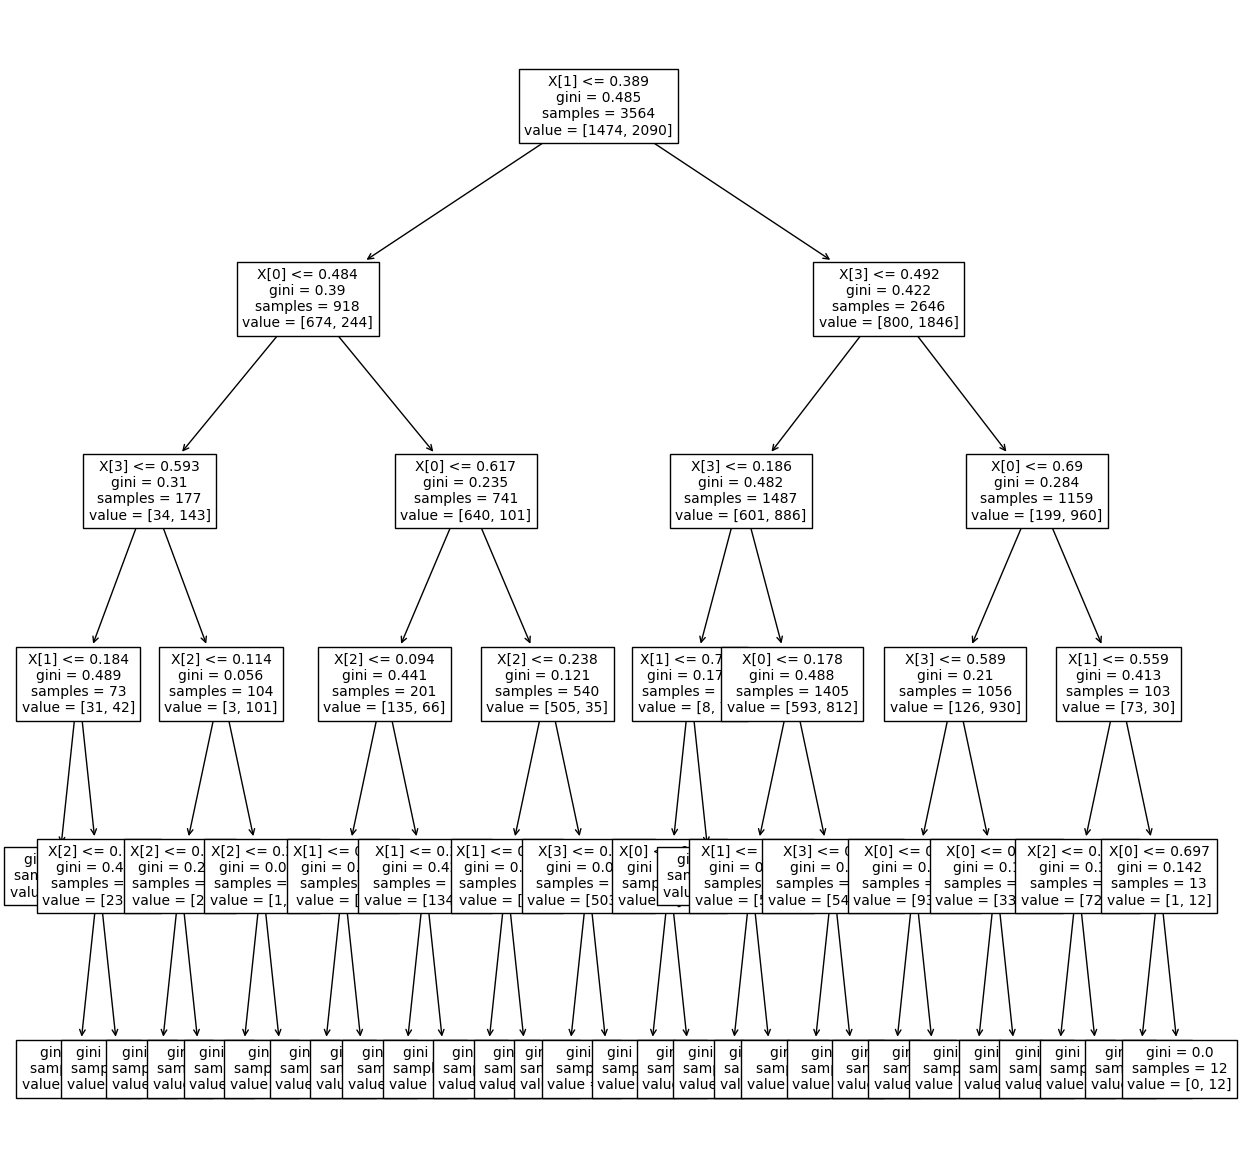

In [23]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(test_X, test_y)
plt.figure(figsize=(15,15))
tree.plot_tree(clf,fontsize=10)
plt.show

Kontrola preučenia.

Nastavili sme dosť nízku hĺbku stromu, preto môžeme vidieť,že presnosť algoritmov je podobná a teda nedošlo k preučeniu

In [11]:
print('Training accuracy: ',clf.score(train_X,train_y))
print('Test Accuracy: ',clf.score(test_X, test_y))

Training accuracy:  0.7856627375511186
Test Accuracy:  0.7651515151515151


## Porovnanie s našou implementáciou 

In [12]:
print(classification_report(test_y,clf.predict(test_X)))

              precision    recall  f1-score   support

         0.0       0.85      0.52      0.65      1474
         1.0       0.74      0.94      0.82      2090

    accuracy                           0.77      3564
   macro avg       0.79      0.73      0.74      3564
weighted avg       0.78      0.77      0.75      3564



Ako môžeme vidieť, rozhodovací strom tu dosahuje úspešnosť 0,75, čo je v porovnaní s našim algoritmom výrazne zlepšenie. Je t spôsobené tým, že rozhodovací strom pracuje s rôznymi pravidlami, aby sa dopracoval k čo najlepšiemu výsledku, pri čom v našom 1R, sme hľadali iba jedno najlepšie pravidlo na predikciu.

# Optimalizácia

In [13]:
test_X = test.drop(columns="warning")
test_y = test.warning.copy()
train_X = train.drop(columns="warning")
train_y = train.warning.copy()

### Výber parametrov 

Skúšali sme rôzne nastavenie pre tieto parametre na dosiahnutie čo najoptimálnejšieho výsledku:

- criterion - slúži na určovanie kvality rozdelenia v rozhodovacom strome
    - Gini - Gini Index je nákladová, ktorú používajú stromy na výber funkcie, ktorá sa použije na rozdelenie údajov a v akom bode sa má stĺpec rozdeliť.
    - Entropia meria náhodnosť informácií, ktoré spracovávame. Čím vyššia je náhodnosť, tým vyššia je entropia.
- max_depth -  určuje maximálnu hĺbku stromu, ak nie je zadaný, strom sarozširuje, kým listy neobsahujú len jednu hodnot. Vhodné nastavenie tohto parametra je dôležiité, aby nenastalo preučenie
- min_samples_split - aký je ptrebný minimálny počet vzoriek v uzle, ktorý nie je list na jeho rozdelenie. Bez tohto parametra, sa strom buderozvetvvať v každom uzle, kde sú dva záznamy. 
- min_samples_leaf - minimálny počet vzoriek, ktoré je nutné ponechať v uzle a teda, aby sme daný uzol značili ako list a nedelili ho ďalej. Rozdelenie sa bude brať do úvahy len vtedy, ak je na ľavej a pravej vetve aspoň min_samples_leaf vzoriek.
- splitter - metóda použitá na rozdelenie uzla v strome. Na výber sú dve metódy
    - best - vyhodnocuje všetky rozdelenia pomocou criterion pred rozdelením
    - random - používa funkciu so vstupmi min_feature_value, max_feature_value a random_state. Kvôli tomu je menej náchylný na preučenie.
- min_impurity_decrease - slúži na kontrolu rozdelenia uzlov pomocou Gini Impurity - rozdelenie sa uskutoční iba vtedy, ak zníži hodnotu Gini Impurity, ktorá je väčšia alebo rovná hodnote min_impurity_decrease. Predvolená hodnota je 0. 
 

In [14]:
space={
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [1,3,4,6,8,9,10,11,12,15,17],
    'min_samples_split' : [4,5,6,7,9,10,12,15,20],
    'min_samples_leaf' :[2,3,4,5,8,11,13,15,20,24,27,35],
    'splitter' : ['best', 'random'],
    'min_impurity_decrease' : [0,0.1,0.15],
}

Testovali sme ch pomocou krížovej validácie, kde sme si zvolili rozdeliť množinu dát na 5 častí.

In [15]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)

Prehľadávanie možností najlepších parametrov pomocou Grid Search. Poo rozdelení dát sa na jednotlivých častiach skúšajú hyperparametre rozhodovacieho stromu. Vďaka tomu, že sa testujú na viacerých častiach sa snažíme predísť preučniu,keďže každá časť predstavuje samostatný malý dataset.

In [16]:
model = tree.DecisionTreeClassifier()
search = GridSearchCV(model, space, scoring='accuracy', cv=cv, refit=True)
result = search.fit(train_X, train_y)

Nájdené najlepšie parametre

In [17]:
print(result.best_params_)

{'criterion': 'gini', 'max_depth': 12, 'min_impurity_decrease': 0, 'min_samples_leaf': 4, 'min_samples_split': 9, 'splitter': 'random'}


Spustenie algoritmu už s vybranými najlepšími parametrami na testovacej množine

In [18]:
best_model = result.best_estimator_
prediction = best_model.predict(test_X)
print("Accuracy: ", accuracy_score(test_y, prediction))
print("Precision: ", precision_score(test_y, prediction))
print("Recall: ", recall_score(test_y, prediction))

Accuracy:  0.7724466891133558
Precision:  0.7710894446799491
Recall:  0.8703349282296651


Môžeme vidieť, že výsledky sú lepšie v porovnaní s predchádzajúcimi algoritmami, hoci v porovnaní s rozhodvacím stromom bez optimalizácie, je to zlepšenie oveľa menšie, akoby sme chceli a čakali. Môže to byť spôsobené vybratými údajmi v testovacej a trénovacej množine alebo sú optimálnejšie hyperparametre, ktoré sme neuvideli v zozname a teda gridsearch ich nemohol zobrať do úvahy pri hľadaní najlepšieho riešenia.  

## Kontorla preučenia

In [19]:
print('Training accuracy: ',best_model.score(train_X,train_y))
print('Test Accuracy: ',best_model.score(test_X, test_y))

Training accuracy:  0.8049073851335098
Test Accuracy:  0.7724466891133558


Môžeme vidieť, že presnosť algoritmu je pri trénovacej množine podobná, preto môžeme predpokladať, že nedošlo k preučeniu. V prípade keby bola úspešnosť algoritmu na trénovacej množine príliš veľká v porovnaní s testovacou množinou,došli by sme k záveru, že to parí k prípadom ovefittingu.